In [26]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import axs

import mysql.connector as mariadb

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# plt.savefig('big_lc_clr.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

Some plots/things to make from the alert-db itself:

- histogram of "Sgscoreps1", the star/galaxy score from PS1
- 
- color-color plot (r-i, g-r), w/ points colored by the "Sgscoreps1" parameter

In [4]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark


In [5]:
spark_session = spark_start('/epyc/users/jrad/ztf_alertCMD/sparkler/')

In [6]:
catalog = axs.AxsCatalog(spark_session)

In [8]:
catalog.list_tables().keys()

dict_keys(['sdss_zoned1am_hd', 'gaia_zoned1am_hd', 'gaia_dr2_1am_dup', 'sdss_zoned1am_700lc', 'gaia_dr2_700lc2', 'allwise_1am_dup', 'gaia_sdss_wise_1asec', 'gaia_sdss_3asec', 'ztf_1am_old', 'ztf_exposures', 'ztf_1am_lc', 'ztf_1am', 'ztf_1am_test', 'sesar_rrlyrae', 'ztf_fid1_sdss_stars_lt20_2asec', 'ztf_fid2_sdss_stars_lt20_2asec', 'ztf_fid3_sdss_stars_lt20_2asec', 'sdss_dr9_qso_s82', 'faraway_training_dataset', 'faraway_labeled_training_dataset', 'ztf_nobs100', 'jnk_ztf_test', 'jnk_ztf_test2', 'ztf1000', 'ztf10', 'ztf_dec18', 'asassn_variability_catalog', 'ztf10_assasn', 'ztf10_assasn_cesium', 'ztf10_assasn_best', 'ztf10_assasn_cesium_best', 'unwise_v1', 'cklein_flare', 'unwise_v2', 'cesium_speedtest_ztfsample', 'paula_listcvs', 'nemec_rrlyrae_metalicity', 'dambis_rrlyrae_metalicity', 'sdss_500b_28e_10800z', 'gaia_500b_28e_10800z', 'allwise_500b_28e_10800z', 'ztf_500b_28e_10800z', 'ztf_mar19_all', 'ztf_dr1_s82_qso', 'green19_stellar_params', 'catalina_variables_n', 'caltech_rosat_perio

## Start with ZTF10_ASSASN

this (i think) is an xmatch of ZTF objects w/ at least 10 alerts, matched to the ASAS-SN Variable Stars catalog

Note: this isn't what I really *want*, since it doesn't have ALL the ZTF alerts... but it's a place to start

In [37]:
ztf10 = catalog.load('ztf10_assasn')

In [38]:
ztf10.count()

118387

In [92]:
ztf10.columns

['objectId',
 'type',
 'ra',
 'dec',
 'filter',
 'jd',
 'magpsf',
 'sigmapsf',
 'diffmaglim',
 'rb',
 'isdiffpos',
 'magnr',
 'sigmagnr',
 'distnr',
 'classtar',
 'sgscore1',
 'distpsnr1',
 'pid',
 'magzpsci',
 'magzpsciunc',
 'ref_flux',
 'ref_sigflux',
 'difference_flux',
 'difference_sigflux',
 'dc_flux',
 'dc_sigflux',
 'dc_mag',
 'dc_sigmag',
 'ASAS-SN_Name',
 'Other_Names',
 'LCID',
 'Mean_VMag',
 'Amplitude',
 'Period',
 'Url',
 'Reference',
 'Dist',
 'Parallax',
 'Parallax_Error',
 'Gmag',
 'Bpmag',
 'Rpmag',
 'Jmag',
 'Hmag',
 'Kmag',
 'W1mag',
 'W2mag',
 'W3mag',
 'W4mag',
 'BP-RR',
 'J-K',
 'W1-W2',
 'W3-W4',
 'Sllk_Statistic',
 'RF_Regression_Score',
 'Classification_Probability',
 'Epoch_HJD',
 'axsdist',
 '__index_level_0__',
 'zone',
 'dup']

In [42]:
test = ztf10.select(ztf10['ra'], ztf10['dec']).toPandas()

<IPython.core.display.Javascript object>


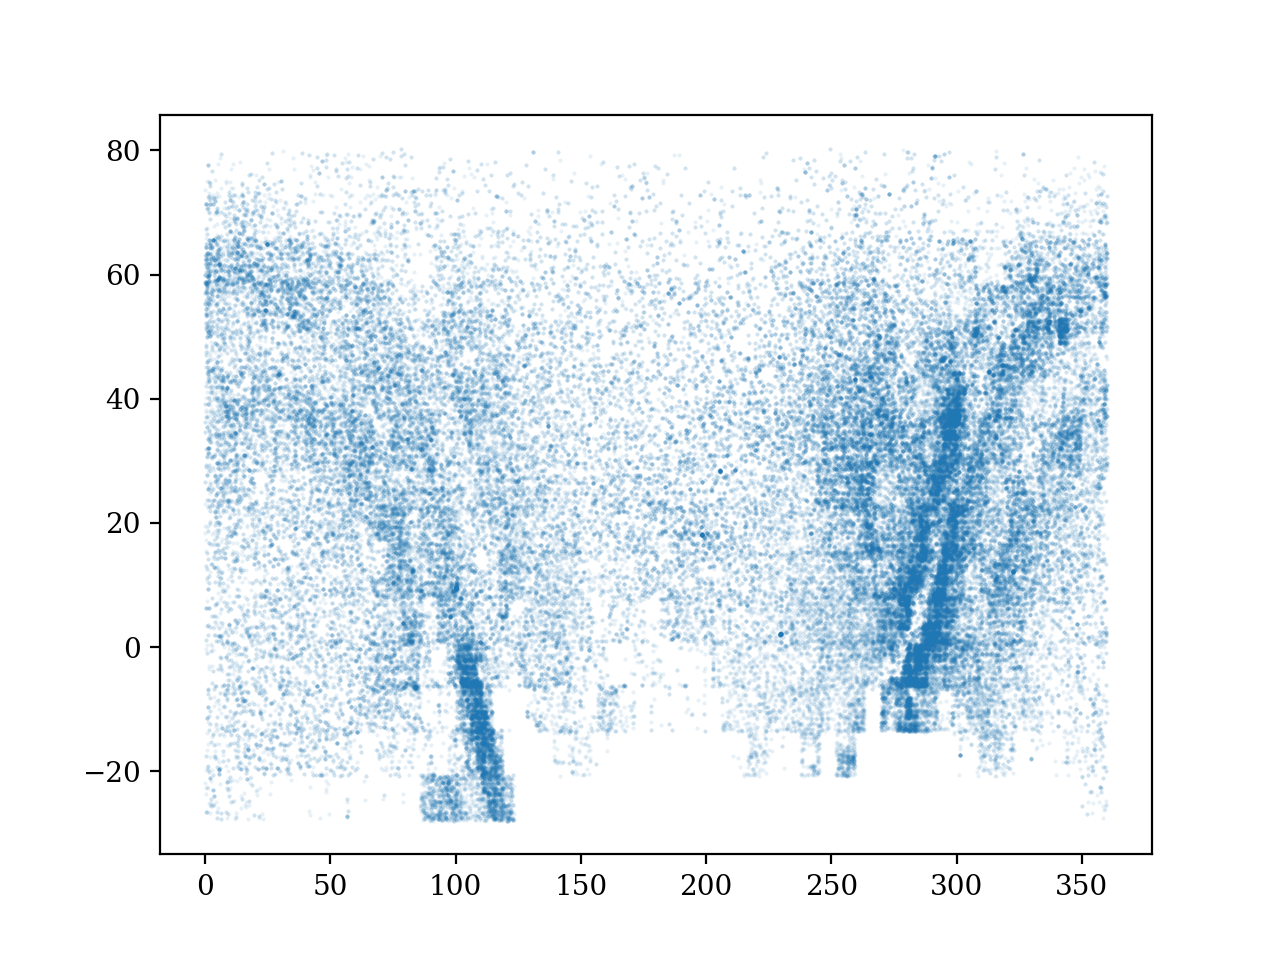

In [47]:
plt.scatter(test['ra'], test['dec'], s=1, marker='.', alpha=0.1)

In [93]:
data = ztf10.select(ztf10['ra'], ztf10['dec'], ztf10['BP-RR'], ztf10['Parallax'], ztf10['Parallax_Error'],
                    ztf10['Dist'], ztf10['Gmag'], ztf10['sgscore1']).toPandas()

In [94]:
sgscore1 = data['sgscore1'].map(np.mean)

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


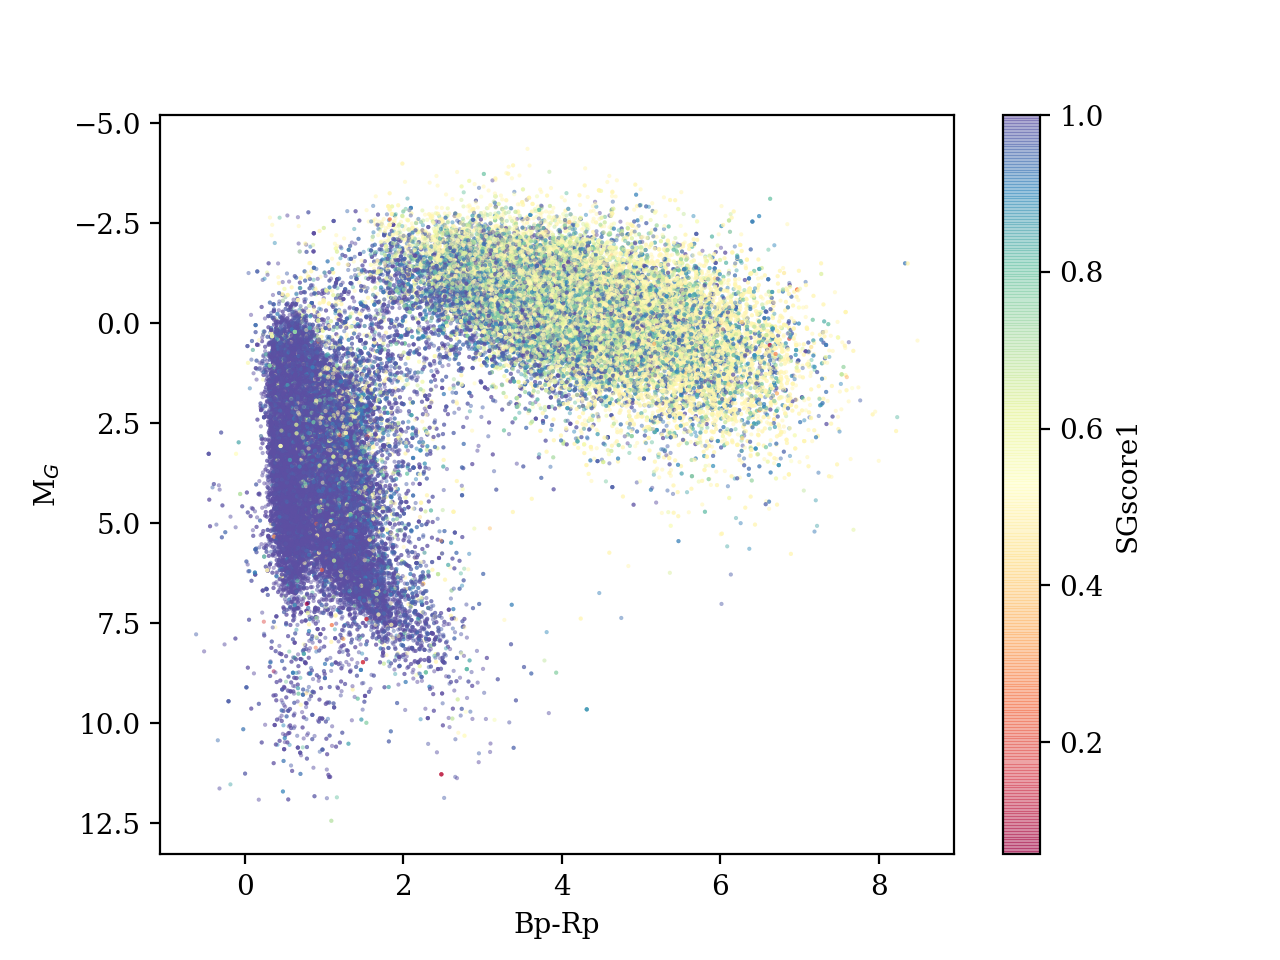

Text(0, 0.5, 'M$_G$')

In [88]:
plt.scatter(data['BP-RR'], data['Gmag'] - 5*np.log10(data['Dist'])+5, 
            s=1, alpha=0.5, marker='.', c=sgscore1, cmap=plt.cm.Spectral)

plt.gca().invert_yaxis()

cb=plt.colorbar()
cb.set_label('SGscore1')

plt.xlabel('Bp-Rp')
plt.ylabel(r'M$_G$')

<IPython.core.display.Javascript object>


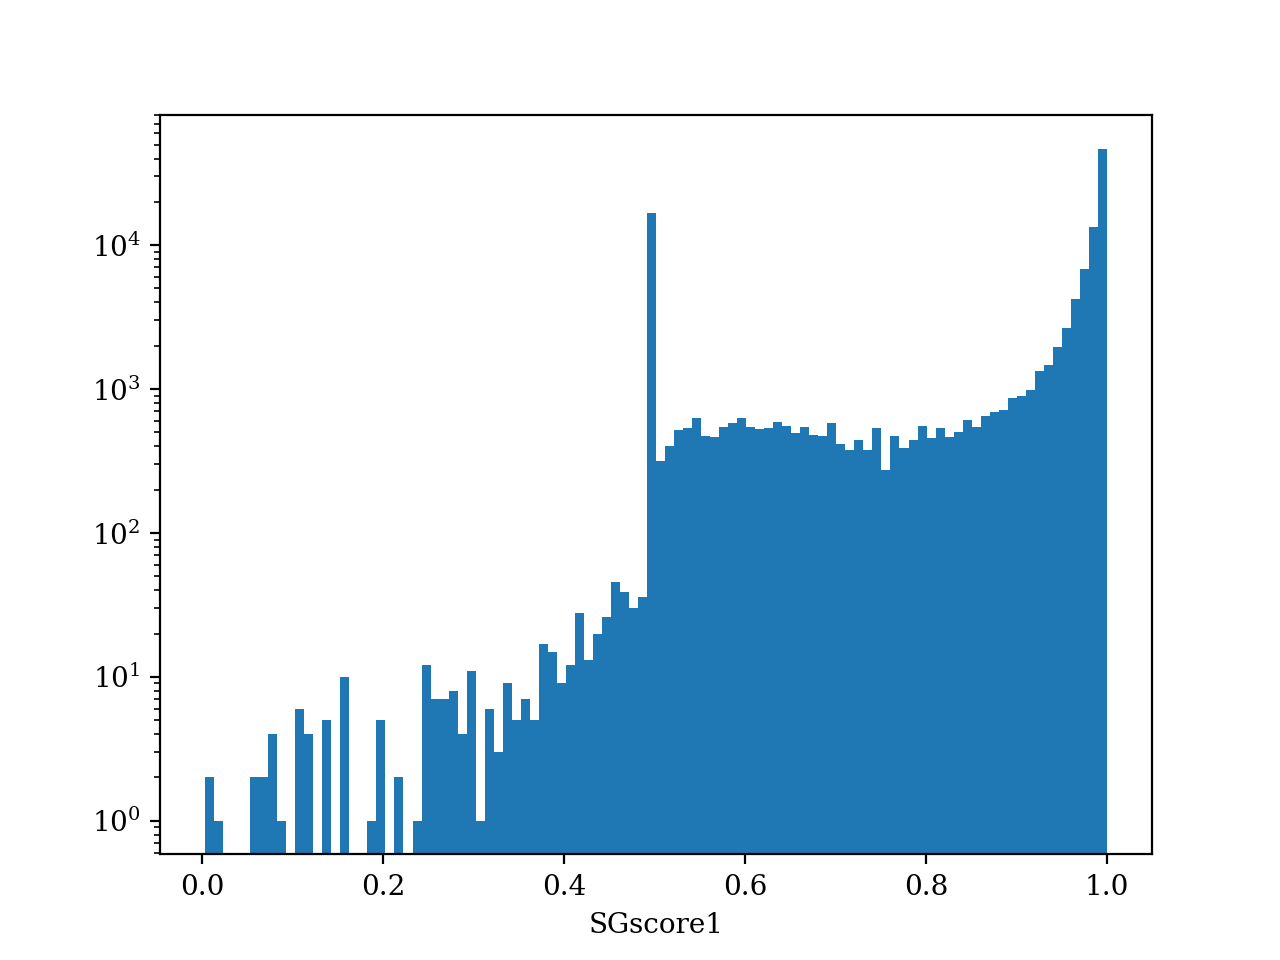

/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'SGscore1')

In [90]:
_ = plt.hist(sgscore1, bins=100)
plt.yscale("log")
plt.xlabel('SGscore1')

In [112]:
ok = ((data['Parallax_Error'].values / data['Parallax'].values < 0.025) & 
      (sgscore1 > 0.9) & 
      (data['Dist'].values < 1700))

sum(ok)

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


7782

<IPython.core.display.Javascript object>


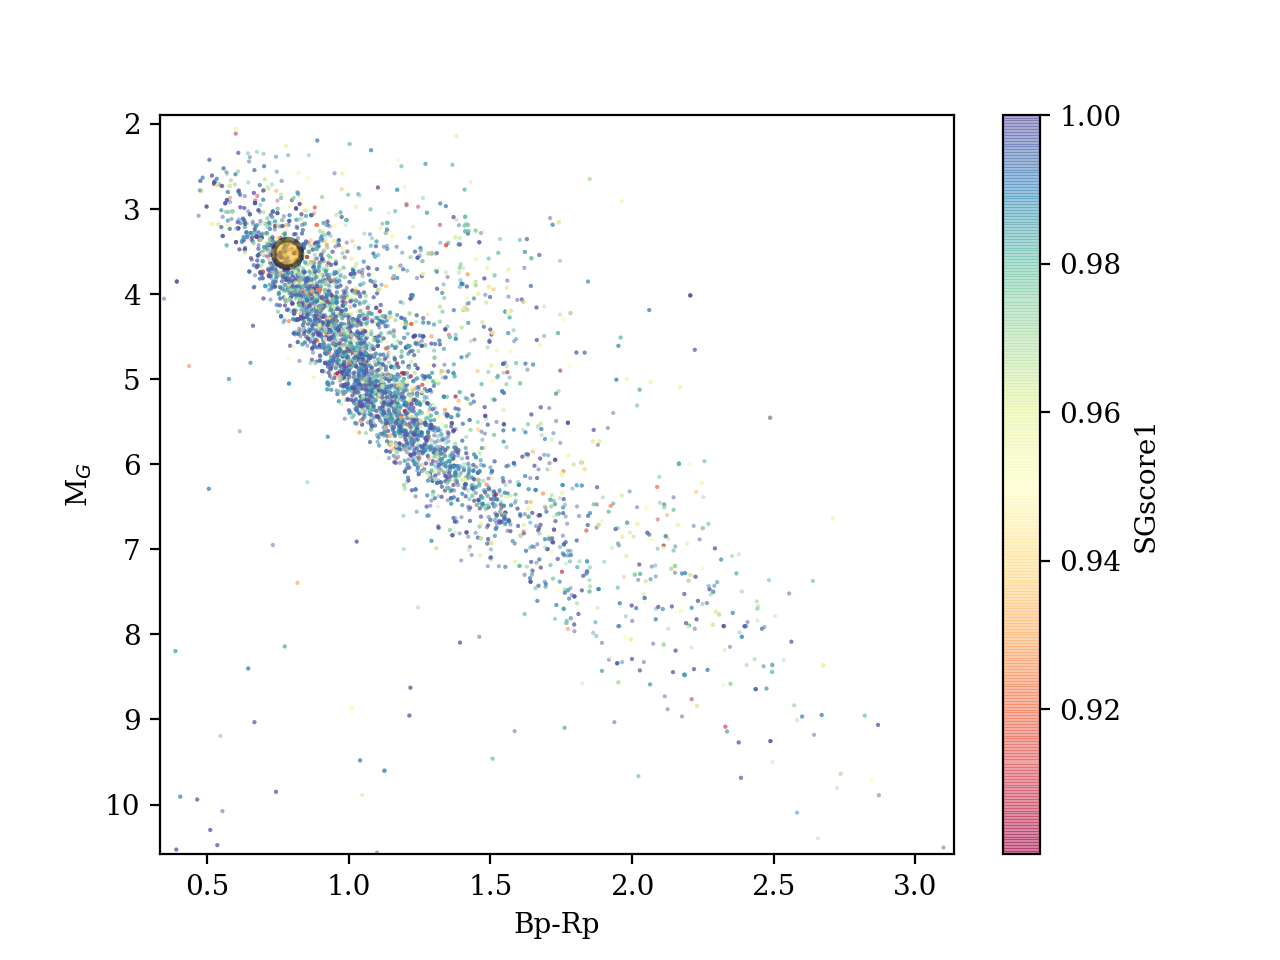

Text(0, 0.5, 'M$_G$')

In [123]:
plt.scatter(data['BP-RR'][ok], data['Gmag'][ok] - 5*np.log10(data['Dist'][ok])+5, c=sgscore1[ok], 
            s=1, alpha=0.5, marker='.', cmap=plt.cm.Spectral)
cb=plt.colorbar()
cb.set_label('SGscore1')

bp_rp = 0.7817 # mag
phot_g_mean_mag = 11.7626 # mag
parallax = 2.2185 # mas
distance = 445.026195912852984 # pc

plt.scatter([bp_rp], [phot_g_mean_mag-5*np.log10(distance)+5], 
            c='orange', s=100, lw=2, edgecolors='k', alpha=0.5)

plt.gca().invert_yaxis()


plt.xlabel('Bp-Rp')
plt.ylabel(r'M$_G$')

In [117]:
# _ = plt.hist(data['Dist'][ok], bins=100)

In [128]:
import mysql.connector as mariadb
con = mariadb.connect(user='ztf', database='ztf')
cur = con.cursor()

In [129]:
pd.read_sql_query('SHOW databases;', con)

,Database
0,information_schema
1,ztf


In [131]:
pd.read_sql_query('show tables;', con)

,Tables_in_ztf
0,alerts
1,alerts_ORG
2,alerts_limmag
3,summary


In [132]:
pd.read_sql_query('select count(*) from alerts;', con)

,count(*)
0,131020476


In [133]:
pd.read_sql_query('describe alerts;', con)

,Field,Type,Null,Key,Default,Extra
0,objectId,varchar(20),YES,MUL,None,
1,jd,double,YES,,None,
2,fid,int(11),YES,,None,
3,pid,bigint(20),YES,,None,
4,diffmaglim,float,YES,,None,
5,programid,int(11),YES,,None,
6,candid,bigint(20),YES,,None,
7,isdiffpos,varchar(10),YES,,None,
8,tblid,bigint(20),YES,,None,
9,nid,int(11),YES,,None,
